In [1]:
# Adrian Marinovich
# Springboard - Data Science Career Track
# Ultimate Take-home Exercise
# January 25, 2019
#

In [2]:
import numpy as np
import pandas as pd
import json
import sklearn.model_selection

from pandas.io.json import json_normalize
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC 

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid")
sns.set_context("paper")
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

In [3]:
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)

## Part 1. Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [4]:
# Read the josn in to a pandas dataframe
logins_df = pd.read_json('sb_data/logins.json')

In [5]:
# View number of rows, columns
logins_df.shape

(93142, 1)

In [6]:
# View data types
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [7]:
# View top of dataframe
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [8]:
# View basic stats
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [9]:
# Create new dataframe that converts data type
l_dti = pd.DatetimeIndex(logins_df['login_time'])

In [10]:
# Check data type
type(l_dti)

pandas.core.indexes.datetimes.DatetimeIndex

In [11]:
# Create dataframe with appropriate index
l_df = pd.DataFrame(data=l_dti, index=l_dti)

In [12]:
# Check
l_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [13]:
# Check
l_df.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


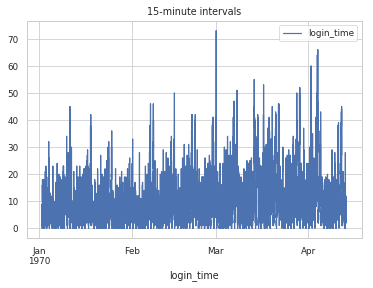

In [14]:
# View in 15 minute intervals
l_df.resample('15min').count().plot(title='15-minute intervals')

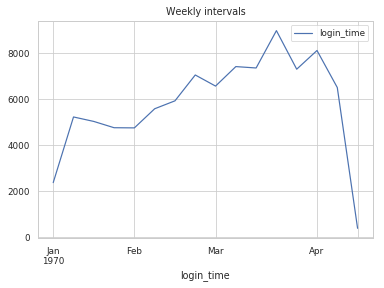

In [15]:
# This is very busy, so try viewing in weekly intervals
l_df.resample('W').count().plot(title='Weekly intervals')

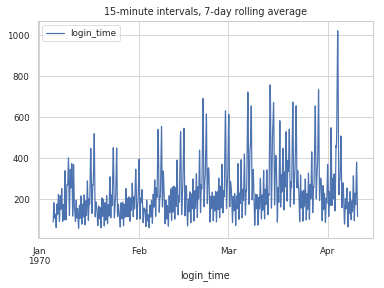

In [16]:
# Try viewing the 15-minute intervals with rolling average

# adapted from:
#  https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

m15 = l_df.resample('15min').count()
m15.rolling(672, center=True,
            win_type='gaussian').sum(std=10).plot(style=['-'], 
            title='15-minute intervals, 7-day rolling average')

### From the above plots, there appear to be overall increased login frequencies as time goes by from January through April. Since we don't have multiple years to look at, we should not forget this could simply be a seasonal effect that we can't appreciate with this <1 year interval of data.  

### There also appears to be some periodicity within each month, roughly weekly. So we will take a look at the data grouped into days of the week:

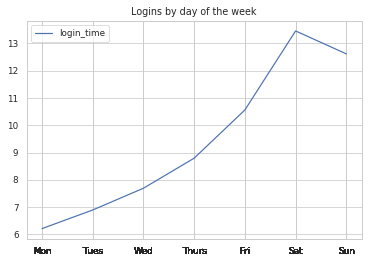

In [17]:
by_weekday = m15.groupby(m15.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(xticks=m15.index.dayofweek, style=['-'],
                title='Logins by day of the week')

### This does appear to show a clear increase in logins from Monday to Friday, and then a jump to even higher login frequencies during the weekend, with a peak on Saturdays.

### This behooves looking at the daily cycle of logins:

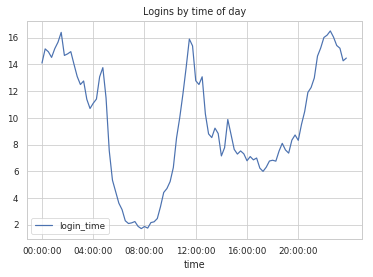

In [18]:
by_time = m15.groupby(m15.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=['-'],
             title='Logins by time of day')

### Overal we see an essentially bimodal daily login cycle, with midday and night-time login peaks. The prominent weekend activity we say previously, however, makes us want to look at the daily cycle broken down by weekdays and weekends:

In [19]:
weekend = np.where(m15.index.weekday < 5, 'Weekday', 'Weekend')
by_time = m15.groupby([weekend, m15.index.time]).mean()

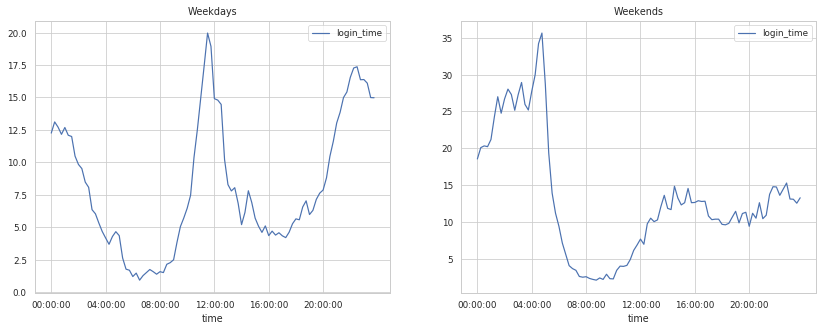

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=['-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=['-']);

### Now we see that the bimodal daily peaks were largely driven by the weekday activity. On the weekends, there's a large late-night peak, and moderate afternoon activity.

## Part 2.  Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


_(1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?_

### Answer:
The primary metric calculates the difference between experimental and control groups in net revenue over the study interval. In other words:

    (Fa - Ca) - Fb

    Where:
 
        Fa = experimental group fare revenue during interval
        
        Ca = cost of toll reimbursement to experimental group during interval

        Fb = control group fare revenue during interval
    
This metric is chosen to ensure that the cost of the toll reimbursement program is factored into the measure of revenue difference, and also to express the metric in a way consistent with the experimental design and statistical significance testing described below. 

Note that total fares for each driver are calculated during the interval, and not just cross-bridge fares. This is because the overall net revenue difference is most important in measuring the success of the program. For instance, it is possible that there is extra time spent on cross-bridge fares that could have been used collecting additional fares without crossing the bridge. Such effects should be captured in the metric. Since differences in cross-bridge fares may nonetheless be worth noting during the study, a secondary, incidental metric may also be chosen that calculates the difference in cross-bridge fares between experimental and control groups.



_(2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:_

_(2a) How you will implement the experiment._

### Answer:
A/B testing is proposed, whereby the drivers are randomized into two groups: experimental and control groups. The experimental group will receive the toll reimbursements for cross-bridge fares during the study interval. To minimize the perception of bias amongst those drivers not receiving reimbursements, the study randomization procedure must be clearly explained to drivers prior to the study start. 

If the financial resources are available, the groups would be balanced to maximize statistical power. More limited resources would mean reducing the size of the experimental group as compared to the control group.

_(2b) What statistical test(s) you will conduct to verify the significance of the
observation._

### Answer:
The unpaired two-sample t-test will be used to determine the statistical significance of the difference in net fare revenue.

_(2c) How you would interpret the results and provide recommendations to the city
operations team along with any caveats._

### Answer:
The primary metric showing the difference in net revenue between groups, the p value calculated from the above-referenced t-test, and the associated 95% confidence interval, would be provided to the operations team. Interpretation would be concerned with whether a significant (p<0.05) gain or loss in net revenue resulted from the toll reimbursement during the study period, and what was the magnitude of that difference. A recommendation to implement toll reimbursement would require both a significant gain in net revenue shown in the study, as well as a magnitude of gain that clearly makes such a program robust against future foreseable variations in its effects and costs of administration.

One caveat would be whether the study was adequately powered to detect a significant difference in net revenue. Without more information on what the current cross-bridge fares are, the toll costs, and some estimate of the expected effect size of toll reimbursement, it is not possible at this time to make a statistical power calculation.

Another caveat is that the experiment cannot be randomized, due to the nature of the intervention (drivers will know whether or not they are being reimbursed). Thus there are possible spillover effects on non-reimbursed control drivers that may diminish or enhance the effect of the intervention, that would not otherwise occur in the event of a full implementation of such an intervention to all drivers.

## Part 3. Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

_(1) Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?_

In [21]:
# Read the josn in to a pandas dataframe
with open('sb_data/ultimate_data_challenge.json') as f:
   retain = json.load(f)

retain_df = pd.DataFrame(retain)

In [22]:
# View basics of dataframe
retain_df.shape

(50000, 12)

In [23]:
retain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [24]:
retain_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [25]:
retain_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [26]:
print('Proportion of riders by city:\n',
      retain_df['city'].value_counts() / retain_df.shape[0])

Proportion of riders by city:
 Winterfell        0.46672
Astapor           0.33068
King's Landing    0.20260
Name: city, dtype: float64


In [27]:
print('Proportion of riders by phone type:\n',
      retain_df['phone'].value_counts() / retain_df.shape[0])

Proportion of riders by phone type:
 iPhone     0.69164
Android    0.30044
Name: phone, dtype: float64


In [28]:
# Create new dummy variable to code categorical variables 
retain_df['iphone'] = retain_df['phone']=='iPhone'

retain_df['astapor'] = retain_df['city']=='Astapor'
retain_df['kings_landing'] = retain_df['city']=='King\'s Landing'
retain_df['winterfell'] = retain_df['city']=='Winterfell'

In [29]:
# Create new variable to code for retention (i.e., trip in last month)
#  then convert to integer from boolean
retain_df['retained'] = retain_df['last_trip_date'].str.find('06', 5, 7) > 0
retain_df.retained = retain_df.retained.astype(int)

In [30]:
print('The proportion of riders retained (i.e., making trip in last month):', 
       retain_df['retained'][retain_df['retained']==True].count() / retain_df.shape[0])

The proportion of riders retained (i.e., making trip in last month): 0.36512


In [31]:
# Normalize select variabeles using min-max scaling 
#  so variables' values are between 0 and 1

var_n = ['avg_dist', 
         'avg_rating_by_driver',
         'avg_rating_of_driver',
         'avg_surge',
         'trips_in_first_30_days',
         'weekday_pct']

for x in var_n:
    retain_df[x] = (retain_df[x] - retain_df[x].min()) / \
                   (retain_df[x].max() - retain_df[x].min())

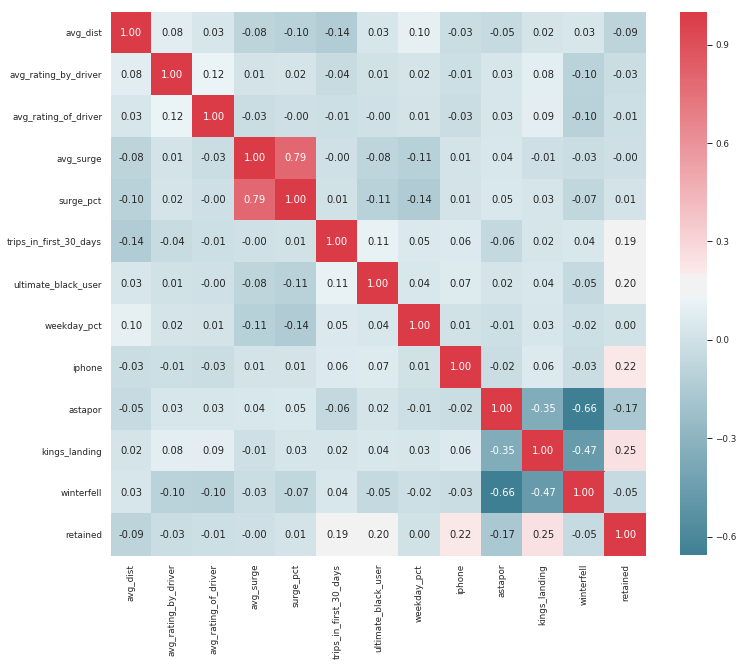

In [32]:
# Create heatmapped correlation matrix of variables
corr = retain_df.corr()
fig, ax = plt.subplots(figsize=(12, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.show()

### Answer:
About 37% of riders were retained (i.e., made a trip in the last month). Examination of the heatmapped correlation matrix above shows that retention has the greatest positive correlations with residence in King's Landing, use of an iPhone (vs. Android phone), being an Ultimate Black rider, and number of trips in the first 30 days. 

Retention is most negatively correlated with residence in Astapor, and shows a smaller negative correlation with average trip distance in the first 30 days. Notably, number of trips in the first 30 days was negatively correlated with trip distance.

There is a negative correlation between weekday percentage and surge percent and average surge multiplier, perhaps reflecting the different daily use cycles seen between weekdays and weekends above.

Not surprisingly, there is a high correlation between the surge percent (percent of trips taken with surge multiplier > 1) and average surge multiplier over all trips. Given they both are representative of the same underlying feature, only one of these variables should be used in the multivariate analysis below.

_(2) Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance._

In [33]:
# Create a predictive analysis dataset using
#  select feature variables and 'retained', 
#  and drop rows with missing values

select_vars = ['avg_dist',
               'avg_rating_by_driver',
               'avg_rating_of_driver',
               'avg_surge',
               'trips_in_first_30_days',
               'ultimate_black_user',
               'weekday_pct',
               'iphone',
               'astapor',
               'kings_landing',
               'winterfell']
selects = select_vars + ['retained']

r_df_nona = retain_df[selects]
r_df_nona = r_df_nona.dropna()

In [34]:
# Split the data into training and test sets
Xlr, Xtestlr, ylr, ytestlr = train_test_split(r_df_nona[select_vars].values, 
                                              r_df_nona.retained.values,
                                              test_size=0.2,
                                              random_state=5)

### We will use three different models: logistic regression,  linear support vector machine (SVM), random forest. These are chosen because all three allow an examination of the contribution of each feature to the prediction.

In [35]:
# Set up logistic regression

lgr_clf = LogisticRegression()

# Fit on the training data
lgr_clf.fit(Xlr, ylr)

# View accuracy on the test data
print(accuracy_score(lgr_clf.predict(Xtestlr), ytestlr))

0.6924182536830759


In [36]:
# Optimize logistic regression parameters using grid search

param_grid = {'C': [0.0001*10**exp for exp in range(0, 8)]}
lgr = LogisticRegression()
lgr_cv = GridSearchCV(lgr, param_grid, cv=5, iid=False)
lgr_cv.fit(Xlr, ylr)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
lgr_cv.best_params_

{'C': 10.0}

In [38]:
lgr_cv.best_score_

0.7011529470107462

In [39]:
# View accuracy on the test data using optimal parameter
clf001 = LogisticRegression(C=lgr_cv.best_params_['C'])
clf001.fit(Xlr, ylr)
accuracy_score(clf001.predict(Xtestlr), ytestlr)

0.6948137501497186

### Since no significant improvement is found with grid search, we will use the original logistic regression model.

In [40]:
# We want to see p values, so we'll get these from chi2

scores, pvalues = chi2(Xlr, ylr)
pvalues

array([6.80251240e-003, 4.83048904e-001, 6.84996019e-001, 9.88466102e-001,
       5.50325742e-014, 9.08502635e-206, 8.83783599e-001, 2.38449336e-109,
       1.36739099e-150, 0.00000000e+000, 1.98965854e-007])

In [41]:
# Create new dataframe showing feature names and 
#  their logistic regression coefficients and p values
lgr_c_p = list(zip(lgr_clf.coef_[0],pvalues))
lgr_features = pd.DataFrame(lgr_c_p,
                                   index = select_vars,
                                   columns=['LGR_Coefficient','p_value'])

In [42]:
lgr_features.iloc[lgr_features['LGR_Coefficient'].abs().argsort()[::-1]]

,LGR_Coefficient,p_value
trips_in_first_30_days,9.174945,5.503257e-14
avg_dist,-5.201561,6.802512e-03
iphone,1.041021,2.384493e-109
ultimate_black_user,0.897173,9.085026e-206
avg_rating_by_driver,-0.874023,4.830489e-01
astapor,-0.812539,1.367391e-150
kings_landing,0.811177,0.000000e+00
avg_surge,0.531756,9.884661e-01
winterfell,-0.294274,1.989659e-07
avg_rating_of_driver,-0.213532,6.849960e-01


### The multivariate approach in this model has shown some differences relative magnitudes of association between the features and retention, compared to the bivariate analysis shown in the correlation matrix above. Notably, trips in the first month, and average trip distance show the strongest associations, and show significant p values. 

### Note that average rating by driver, and average surge multiplier are not significant predictors (p=0.48, and p=0.99, respectively).

### Now we'll compare to a linear SVM model: 

In [43]:
# Set up linear SVM

svml_clf = LinearSVC()

# Fit on the training data
svml_clf.fit(Xlr, ylr)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [44]:
# View accuracy on the test data
y_test_svml = svml_clf.predict(Xtestlr)
print('On test, SVM-Linear accuracy is:', accuracy_score(ytestlr, y_test_svml))

On test, SVM-Linear accuracy is: 0.6930171277997365


### This performs very much like the logistic regression model, but we should see if it weighs the features differently:

In [45]:
svml_features = pd.DataFrame(svml_clf.coef_[0],
                                   index = select_vars,
                                   columns=['SVML_Weight'])

In [46]:
svml_features.iloc[svml_features['SVML_Weight'].abs().argsort()[::-1]]

,SVML_Weight
trips_in_first_30_days,4.191838
avg_dist,-2.239596
iphone,0.400565
ultimate_black_user,0.369659
kings_landing,0.346414
avg_rating_by_driver,-0.343769
astapor,-0.336373
avg_surge,0.215306
winterfell,-0.135711
avg_rating_of_driver,-0.083597


In [47]:
# Set up SVM with RBF classifier, to see if
#  there is substantial improvement in prediction
#  accuracy
svm_clf = SVC(decision_function_shape="ovo")
svm_clf.fit(Xlr, ylr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
y_test_svm = svm_clf.predict(Xtestlr)
print('On test, SVM-RBF accuracy is:', accuracy_score(ytestlr, y_test_svm))

On test, SVM-RBF accuracy is: 0.6964905976763685


### The linear kernal for SVM performs as well as the RBF kernal (on normalized features). We will continue to use the linear SVM since only that kind of SVM allows extraction of feature weights.

### Finally we turn to a random forest model, to see if it allows better prediction accuracy. Note that the feature importances extracted from the random forest are always positive, so cannot give sense of positive or negative association as the logistic and SVM models did.

In [49]:
rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=33)
rf_clf.fit(Xlr, ylr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=33, verbose=0, warm_start=False)

In [50]:
rf_pred = rf_clf.predict(Xtestlr)
print(accuracy_score(ytestlr, rf_pred))

0.7390106599592765


### We see some improvement in accuracy with the random forest. Here we'll extract the feature importances from the model:

In [51]:
rf_features = pd.DataFrame(rf_clf.feature_importances_,
                                   index = select_vars,
                                   columns=['RF_Importance']).sort_values('RF_Importance',
                                   ascending=False)

In [52]:
rf_features

,RF_Importance
avg_dist,0.317378
weekday_pct,0.159851
avg_rating_by_driver,0.114076
avg_surge,0.096237
trips_in_first_30_days,0.095088
avg_rating_of_driver,0.092019
kings_landing,0.039731
iphone,0.032182
ultimate_black_user,0.029805
astapor,0.013702


### We'll combine all the features' contributions to the prediction from the three models to compare side-by-side:

In [53]:
all_features = pd.concat([rf_features, lgr_features.LGR_Coefficient, svml_features], axis=1)

In [54]:
all_features

,RF_Importance,LGR_Coefficient,SVML_Weight
astapor,0.013702,-0.812539,-0.336373
avg_dist,0.317378,-5.201561,-2.239596
avg_rating_by_driver,0.114076,-0.874023,-0.343769
avg_rating_of_driver,0.092019,-0.213532,-0.083597
avg_surge,0.096237,0.531756,0.215306
iphone,0.032182,1.041021,0.400565
kings_landing,0.039731,0.811177,0.346414
trips_in_first_30_days,0.095088,9.174945,4.191838
ultimate_black_user,0.029805,0.897173,0.369659
weekday_pct,0.159851,-0.078330,-0.031311


### To more clearly visualize side-by-side the way different models show features' contributions, we'll normalize the coefficients, weights and importances, after taking absolute values of the coefficients and weights:

In [55]:
var_na = ['RF_Importance', 
          'LGR_Coefficient',
          'SVML_Weight']

for x in var_na:
    all_features[x] = all_features[x].abs()
    all_features[x] = (all_features[x] - all_features[x].min()) / \
                      (all_features[x].max() - all_features[x].min())

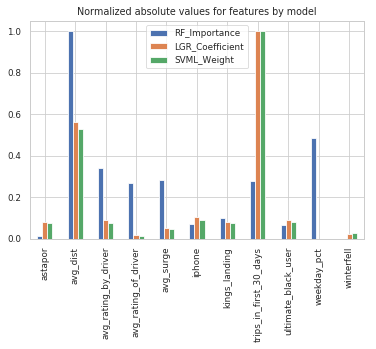

In [56]:
all_features.plot.bar(title='Normalized absolute values for features by model')

### The above figure allows us to see which features show the most consistent relative magnitude of association with retention across models. 

### Number of trips in the first month and average trip distance clearly are important positive and negative predictors, respectively. King's Landing residence, Ultimate Black user, and iPhone user are moderate positive predictors. Astapor residence is a moderate negative predictor in the regression and SVM models. 

### Recall that rating by driver and average surge multiplier were not significant in the regression.

_(3) Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long-term rider retention (again, a few sentences will suffice)._

### Answer:

The results of the logistic regression model, as supported by additional SVM and random forest modeling, indicate that number of trips in the first month, King's Landing residence, use of Ultimate Black, and iPhone use are positive predictors of rider retention, while average trip distance in the first month is a negative predictor. There is some evidence that Astapor residence is also a negative predictor.

Efforts to improve rider retention may be focused on those characteristics of King's Landing and Astapor that could explain positive and negative impacts on retention, respectively. The negative impact of trip distance on retention might be mitigated by changes to pricing and surge algorithms based on mileage. The positive association of average trip number and iPhone use with retention may be self-explanatory. The relation between iPhone use and retention may benefit from further scrutiny, however, as it could indicate smartphone operating-system differences in the Ultimate app that impact rider experience. The positive association of Ultimate Black with retention suggest that inducing further use of this service among riders may lead to greater satisfaction and increase retention.

#### Data description:

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday
